In [1]:
import pandas as pd
import numpy as np
import pathlib
import datetime
from datetime import datetime, timedelta, date
from rich import print
from collections import namedtuple
from dataclasses import dataclass, asdict
import operator
import tomllib
import tomlkit as tml
import json
import xarray as xr
import csvb.ingest as ci
import plotly.express as px
import plotly.graph_objects as go
from collections import namedtuple
#from decimal import Decimal, getcontext

#getcontext().prec = 2
pd.options.mode.copy_on_write = True

In [2]:
Transaction = namedtuple("Transaction", ["Date", "Amount", "From", "To", "Description", "Notes"], defaults=[""])

In [3]:
HOME = pathlib.Path.home()
cfgpth = HOME / ".config" / "csvb" / "config.toml"
with open(cfgpth, 'rb') as f:
    cfg = tomllib.load(f)
RULESPTH = HOME / cfg["paths"]["rules"]
BANKPTH = HOME / cfg["paths"]["bank"]
PRODUCTSPTH = HOME / cfg["paths"]["products"]
ACCT_NAMES = ["Type", "Account", "Subaccount"]
INST_ACCOUNTS = ["Assets:1st Source:Checking",
                 "Assets:Fidelity:HSA",
                 "Assets:Ally:Savins",
                 "Liabilities:NDFCU:Credit Card",
                 "Liabilities:Apple:Credit Card",
                 "Liabilities:Apple:Installments"]

In [4]:
fd  = ci.find_bank_files(HOME / pathlib.Path(cfg["paths"]["bank"])) 

In [5]:
try:
    del apl
except NameError:
    pass
apl = ci.ingest_bank_files(fd["Liabilities:Apple:Credit Card"]["files"],
                           fd["Liabilities:Apple:Credit Card"],
                           RULESPTH)

apl = ci.read_and_apply(apl, RULESPTH / fd["Liabilities:Apple:Credit Card"]["rules_file"])
apl[apl["From"] == ""]

Empty DataFrame
Columns: [Transaction Date, Clearing Date, Description, Merchant, Category, Type, Amount (USD), Purchased By, Amount, From]
Index: []

In [6]:
try:
    del apl_inc
except NameError:
    pass
apl_inc = ci.ingest_bank_files(fd["Liabilities:Apple:Installments"]["files"],
                           fd["Liabilities:Apple:Installments"],
                           RULESPTH)

apl_inc[apl_inc["From"] == ""]

Empty DataFrame
Columns: [Date, Description, Amount, From]
Index: []

In [7]:
try:
    del fst
except NameError:
    pass
fst = ci.ingest_bank_files(fd["Assets:1st Source:Checking"]["files"],
                           fd["Assets:1st Source:Checking"],
                           RULESPTH)

fst = ci.read_and_apply(fst, RULESPTH / fd["Assets:1st Source:Checking"]["rules_file"])

fst[fst["From"] == ""]

Empty DataFrame
Columns: [Transaction Number, Date, Description, Memo, Amount Debit, Amount Credit, Balance, Amount, From, Check Number, Fees  ]
Index: []

In [8]:
try:
    del ally
except NameError:
    pass
ally = ci.ingest_bank_files(fd["Assets:Ally:Savings"]["files"],
                           fd["Assets:Ally:Savings"],
                           RULESPTH)

ally = ci.read_and_apply(ally, RULESPTH / fd["Assets:Ally:Savings"]["rules_file"])

#ally[ally["From"] == ""]
#ally.sort_values("Date")

In [9]:
try:
    del ndfcu
except NameError:
    pass
ndfcu = ci.ingest_bank_files(fd["Liabilities:NDFCU:Credit Card"]["files"],
                           fd["Liabilities:NDFCU:Credit Card"],
                           RULESPTH)

ndfcu = ci.read_and_apply(ndfcu, RULESPTH / fd["Liabilities:NDFCU:Credit Card"]["rules_file"])

ndfcu["Description"] = ndfcu["Description"].fillna("")

ndfcu[ndfcu["From"] == ""]
ndfcu[pd.isnull(ndfcu["From"])]

Empty DataFrame
Columns: [Date, Note, Description, Amount, Balance, From]
Index: []

In [10]:
try:
    del hsa
except NameError:
    pass
hsa = ci.ingest_bank_files(fd["Assets:Fidelity:HSA"]["files"],
                           fd["Assets:Fidelity:HSA"],
                           RULESPTH)
hsa = hsa.rename(columns={"Run Date": "Date",
                          "Action": "Description",
                          "Description": "Note",
                          "Amount ($)": "Amount",
                          
                         }
                )

hsa = ci.read_and_apply(hsa, RULESPTH / fd["Assets:Fidelity:HSA"]["rules_file"])
#hsa[pd.isnull(hsa["From"])]

In [11]:
bank_tables = {"Assets:1st Source:Checking": fst,
               "Liabilities:Apple:Credit Card": apl.rename(columns={"Transaction Date": "Date"}),
              "Assets:Ally:Savings": ally,
              "Liabilities:NDFCU:Credit Card": ndfcu,
              "Liabilities:Apple:Installments": apl_inc,
              "Assets:Fidelity:HSA": hsa}


trans = ci.to_transactions(bank_tables)
trans = trans.sort_values("Date")

In [12]:
try:
    del bal_decl
except NameError:
    pass

bal_decl = pd.read_csv(HOME / pathlib.Path(cfg["paths"]["bank"]) / "balances.csv",
                  header=0,
                  parse_dates=["Date"])


In [13]:
trans = pd.concat([trans, ci.gen_init_balance_trans(bal_decl)], ignore_index=True).sort_values("Date")
#trans[trans["To"] == "Assets:Fidelity:HSA"]

In [14]:
try:
    del ledgers
except NameError:
    pass
    
#ledgers = create_ledgers(trans)
#ledgers = ci.trans_to_ledgers(trans, bal_decl=bal_decl)
#ledgers[ledgers["Account"] == "Assets:1st Source:Checking"]
#ledgers[ledgers["Transaction Pair"] == "Liabilities:Auto:Loan"]
fg = trans.groupby("From")
tg = trans.groupby("To")
fl = {}
for acct in fg.groups:
    fl[acct] = trans.loc[fg.groups[acct]][["Date", "Description", "To"]].rename(columns={"To": "Transaction Pair"})
                                                                                                       
    fl[acct]["Incoming Amount"] = - 1 * trans.loc[fg.groups[acct]]["Amount"]
    fl[acct]["Account String"] = [acct] * len(fl[acct])

tl = {}
for acct in tg.groups:
    tl[acct] = trans.loc[tg.groups[acct]][["Date", "Description", "From"]].rename(columns={"From": "Transaction Pair"})
                                                                                                       
    tl[acct]["Incoming Amount"] = trans.loc[tg.groups[acct]]["Amount"]
    tl[acct]["Account String"] = [acct] * len(tl[acct])

ledgers = pd.concat(list(tl.values()) + list(fl.values())).sort_values("Date", ignore_index=True)

# Split account string to tuples.
acct_tuples = ledgers["Account String"].apply(lambda t:ci.to_triple(t, fill="")).apply(pd.Series).rename(columns=dict(zip(range(3), ACCT_NAMES)))
ledgers = pd.concat([ledgers, acct_tuples], axis="columns")

# Calculate cumulative balance.
ledgers["Balance"] = ledgers.groupby("Account String")["Incoming Amount"].cumsum()

#ledgers


In [15]:
#g = ledge_with_acct["Incoming Amount"].groupby(ledge_with_acct.index).sum("Incoming Amount")
# Select all lines with an initial balance.

clear_virtuals=True

start_date = None
end_date = None #date(2024,1,1)

ltable = ledgers

if start_date is not None:
    ltable = ltable[ltable["Date"] >= pd.Timestamp(start_date)]
if end_date is not None:
    ltable = ltable[ltable["Date"] <= pd.Timestamp(end_date)]


# Group on Accounts
acct_g = ltable.groupby(ACCT_NAMES)

# Choose first and last date of each group from ltable, reassign with column names and set account as multiindex.
start = acct_g.head(1)[["Date", "Balance"] + ACCT_NAMES].rename(columns={"Date": "Start Date", "Balance": "Initial Balance"}).set_index(ACCT_NAMES)
end = acct_g.tail(1)[["Date", "Balance"] + ACCT_NAMES].rename(columns={"Date": "End Date", "Balance": "End Balance"}).set_index(ACCT_NAMES)

#br = br.set_index(pd.MultiIndex.from_tuples(br.index.to_series().apply(ci.to_triple), names=["Type", "Account", "Subaccount"])a
br = pd.concat([start, end],axis="columns")
br["Difference"] = br["End Balance"] - br["Initial Balance"]
br
#acct_g["Date"].groups["Expenses:Reimbursible"]

Start Date  Initial Balance   End Date  \
Type        Account       Subaccount                                           
Assets      1st Source    Checking    2021-12-31          5067.54 2024-04-30   
Liabilities NDFCU         Credit Card 2021-12-31           -86.95 2024-04-26   
Expenses    Groceries                 2021-12-31            86.95 2024-04-27   
Assets      Ally          Savings     2021-12-31          8028.68 2024-05-10   
Expenses    Subscriptions             2021-12-31            14.99 2024-04-28   
...                                          ...              ...        ...   
Income      Paycheck                  2023-02-02          -279.16 2024-06-04   
Expenses    Medical       Dentist     2023-05-26           114.00 2023-05-26   
            Auto          Gas         2023-06-13             7.08 2024-04-26   
            Services                  2024-03-10            59.95 2024-03-10   
            Recovery                  2024-03-13           255.94 2024-03-13   

                                       End Balance  Difference  
Type        Account       Subaccount                            
Assets      1st Source    Checking         6675.63     1608.09  
Liabilities NDFCU         Credit Card      1052.07     1139.02  
Expenses    Groceries                     21398.03    21311.08  
Assets      Ally          Savings         12204.81     4176.13  
Expenses    Subscriptions                  4181.50     4166.51  
...                                            ...         ...  
Income      Paycheck                      -5745.72    -5466.56  
Expenses    Medical       Dentist           114.00        0.00  
            Auto          Gas                80.17       73.09  
            Services                         59.95        0.00  
            Recovery                        255.94        0.00  

[65 rows x 5 columns]

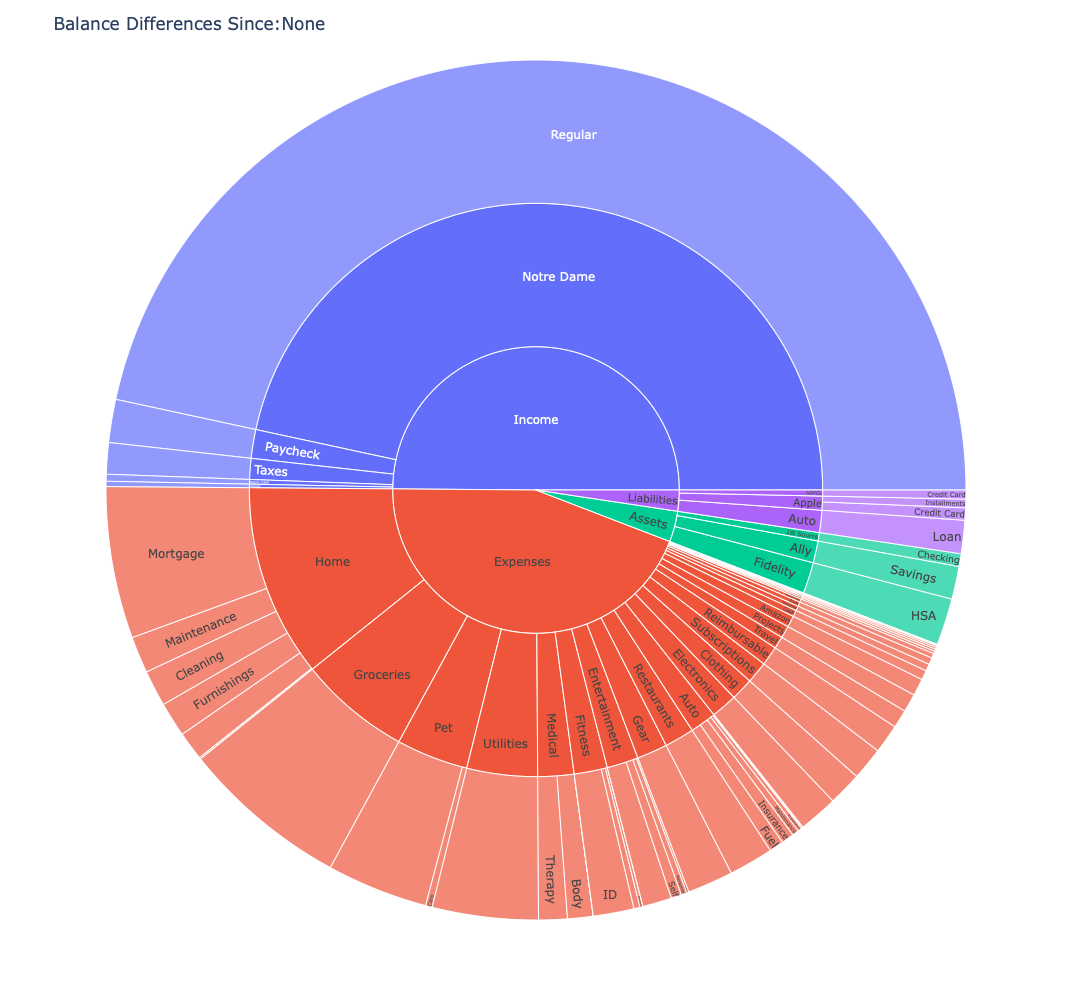

In [16]:
#cutoff_ledgers["Liabilities:Auto:Loan"].iloc[-2:-1]
#cb = ci.balances(ledgers)
#cb
df = br
df = pd.DataFrame({"Type": df.index.get_level_values("Type"),
                   "Account": df.index.get_level_values("Account"),
                   "Subaccount": df.index.get_level_values("Subaccount"),
                   "Difference": df["Difference"].apply(np.abs)})
df = df.loc[df["Type"] != "Transfer"]
df = df.loc[df["Type"] != "Equity"]
df = df.fillna("")
df = df.replace(np.inf,0)
#df = df.loc[
sbfig = px.sunburst(df, path=["Type", "Account", "Subaccount"], values="Difference")
sbfig.update_layout(height=1000, title=f"Balance Differences Since:{str(start_date)}")
sbfig.show()
#sbfig.data

In [17]:
#flow = trans.groupby(["From", "To"])
pt = trans.copy()
pt.loc[trans["Amount"] < 0, "To"] = trans.loc[trans["Amount"] < 0, "From"]
pt.loc[trans["Amount"] < 0, "From"] = trans.loc[trans["Amount"] < 0, "To"]
pt.loc[trans["Amount"] < 0, "Amount"] = -1 * trans.loc[trans["Amount"] < 0, "Amount"]
flow = pt.groupby(["From", "To"])
flow_df = pd.DataFrame(flow.Amount.aggregate("sum"))

In [18]:
accts = list(ci.accounts(flow_df.index.to_frame()))

labels = accts
sources = [accts.index(a) for a in flow_df.index.to_frame()["From"].values]
targets = [accts.index(a) for a in flow_df.index.to_frame()["To"].values]
values = flow_df["Amount"]

f = go.Figure(data=[go.Sankey(
    node = dict(
        pad=15,
        thickness = 5,
        line=dict(color = "black", width = 0.5),
        label = labels
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values.values,
    )
)
                   ]
             )


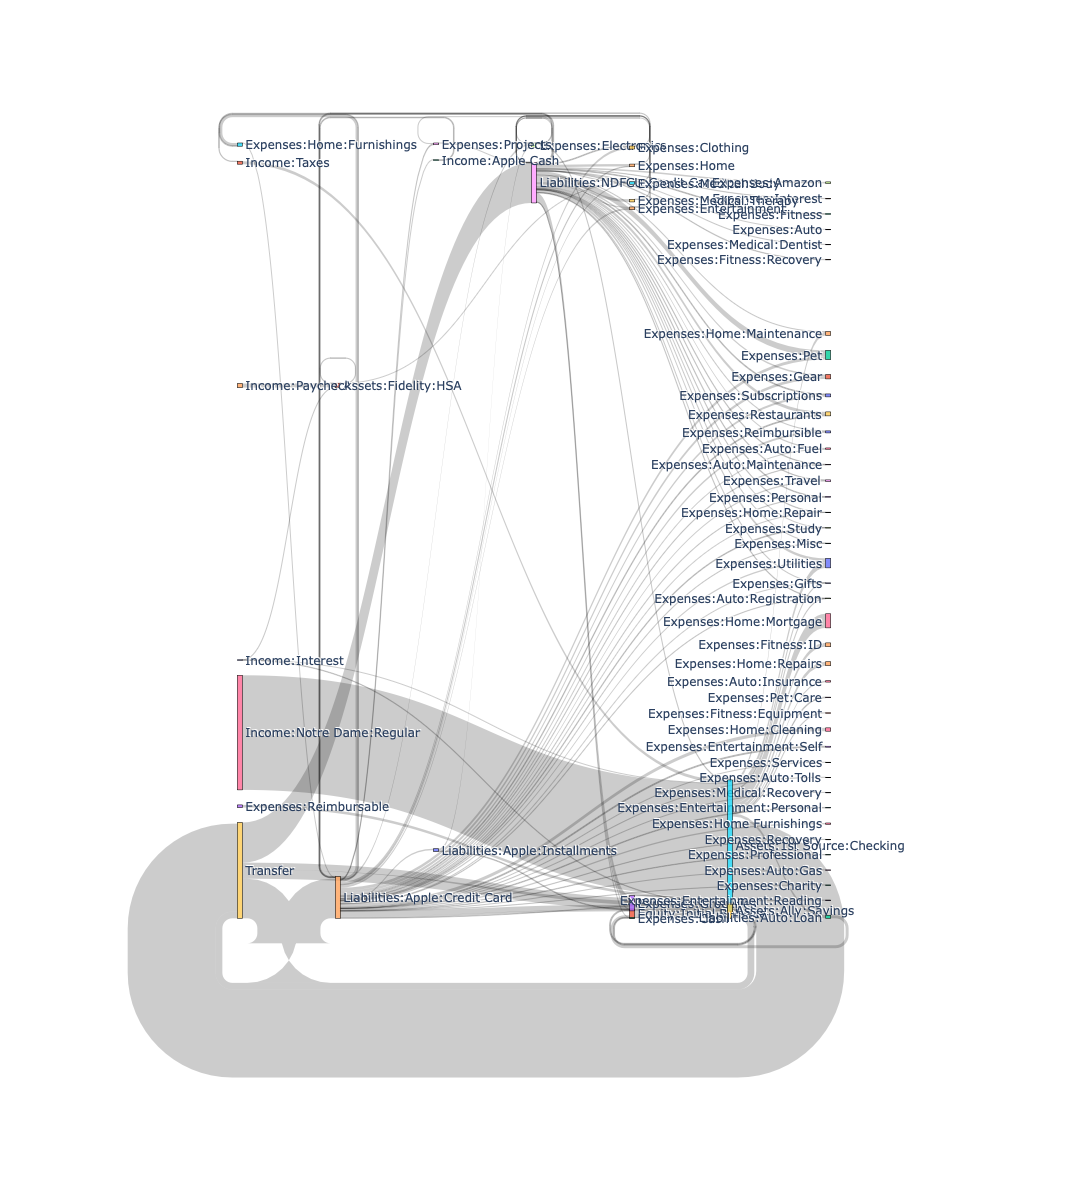

In [19]:
f.update_layout(height=1200)
f.show()

In [20]:
ltable = ledgers.sort_values("Date")
ltable = ltable[ltable["Date"] >= pd.Timestamp("2022-12-31")]
acct_g = ltable.groupby(ACCT_NAMES)
# We need a df of zero items to make resample create zeros for every month in the time frame.
# Otherwise, the means aren't correct over the full time frame.

# Find the groups for which the first date isn't the min and the last date isn't the max in ltable.
# Then create a df with a row for each account that doens't start at the first date or end at the end date.
# The following line, fines the groups that do'nt match, makes a df, then assigns the constant start or end value.
zeros=pd.concat([pd.DataFrame(~(acct_g["Date"].min() == ltable["Date"].min())).assign(Date=ltable["Date"].min()),
                 pd.DataFrame(~(acct_g["Date"].max() == ltable["Date"].max())).assign(Date=ltable["Date"].max())], axis="rows")
# Now fill out the other values and make the multi index a set of rows so that we can add it to ltable.
zeros = zeros.assign(Description="Fake Zero", Balance=0.0, Amount=0.0).rename(columns={"Amount": "Incoming Amount"})
#zeros[zeros["Date"] == ltable["Date"].max()]]
zeros.loc[zeros["Date"] == ltable["Date"].max(), "Balance"] = acct_g.last()["Balance"]
zeros.loc[:, "Account String"] = zeros.index.to_series().apply(":".join)
ltable = pd.concat([ltable, zeros.reset_index()], axis="rows").reset_index(drop=True)
acct_g = ltable.groupby(ACCT_NAMES)

monthly_sum = ltable.set_index("Date").sort_index().groupby(by=ACCT_NAMES).resample("ME", kind="period").sum()["Incoming Amount"]
monthly_mean = monthly_sum.groupby(ACCT_NAMES).mean()
#monthly_mean = pd.concat([monthly_mean, monthly_sum.groupby(ACCT_NAMES).std().rename("std")], axis="columns")
#monthly_sum.groupby(ACCT_NAMES)

/var/folders/42/qqsltqsj6fl30wl4xm41gs4m0000gn/T/ipykernel_7814/3741240659.py:16: PerformanceWarning:

indexing past lexsort depth may impact performance.



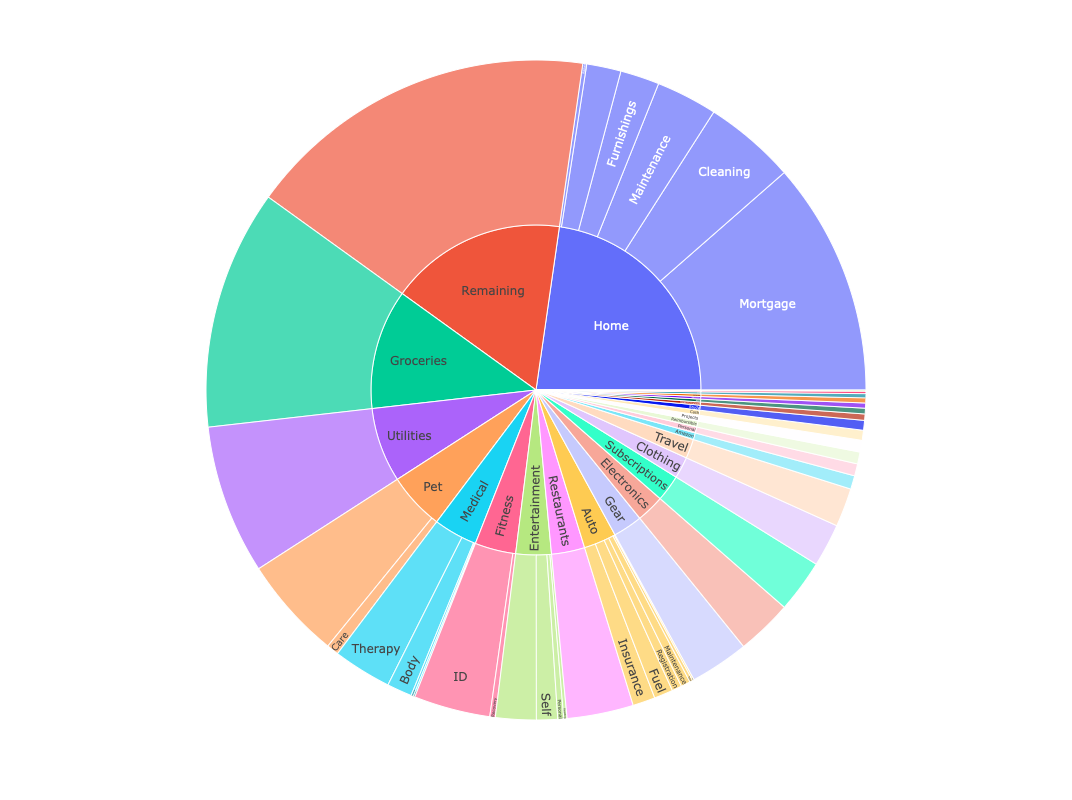

In [21]:
mean_expenses = monthly_mean["Expenses"]
#mean_expenses.index = mean_expenses.index.to_series().apply(":".join)
#px.pie(mean_expenses.sort_values(), height=600)
sb_mean_exp = mean_expenses.reset_index()

df = pd.concat([sb_mean_exp, pd.DataFrame({"Account": "Remaining",
                                       "Subaccount":"",
                                      "Incoming Amount": 5335.69 - sb_mean_exp.sum()["Incoming Amount"]},
                                    index=[sb_mean_exp.index[-1]+1])])
px.sunburst(df, path=["Account", "Subaccount"], values="Incoming Amount", height=800)

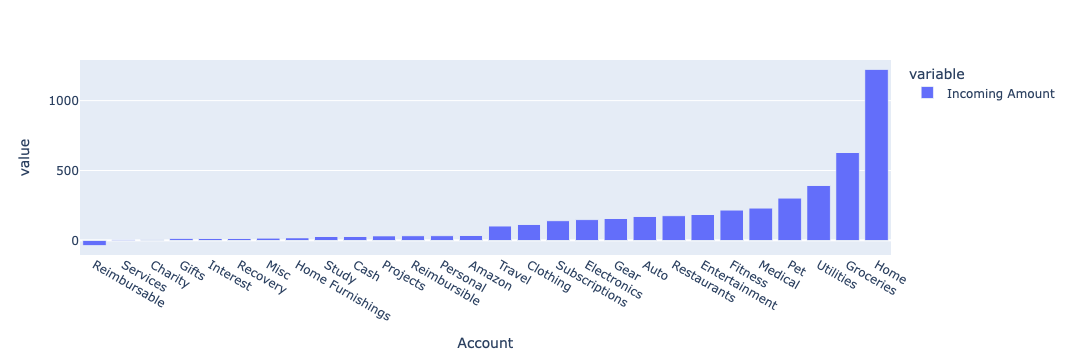

In [22]:
df = monthly_mean["Expenses"].groupby(["Account"]).sum().sort_values()
px.bar(df)

In [23]:
pmsum = monthly_sum["Expenses"]#.reset_index()
#pmsum["Acctstr"] = pmsum["Account"] + ":" + pmsum["Subaccount"]
#pmsum["Date"] = pmsum["Date"].astype(object).apply(pd.Period.to_timestamp)

In [24]:
pmsum=pmsum.reorder_levels(["Date", "Account", "Subaccount"])

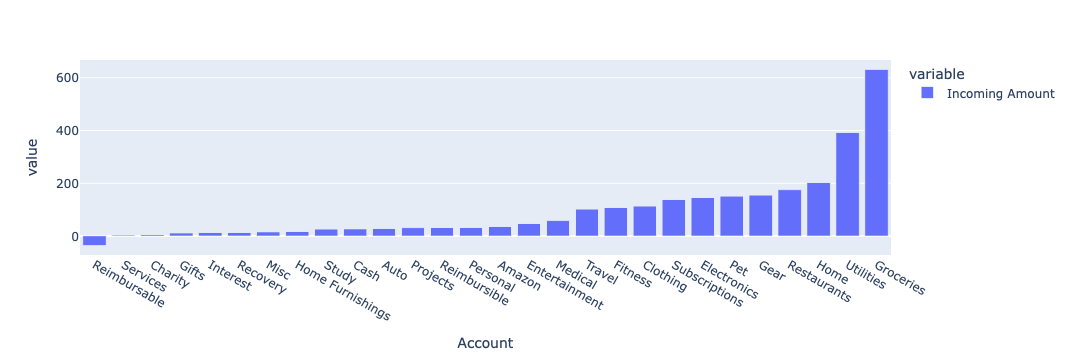

In [25]:
df = monthly_sum["Expenses"]
#px.bar(df.sort_values())
df = df.groupby("Account").mean()
px.bar(df.sort_values())

In [26]:
pdextension = pd.period_range(start = pmsum.index.levels[0][-1], end=pd.Period("2024-12"), freq="M")[1:]

In [27]:
import itertools
pd.MultiIndex.from_tuples([(a, *b) for a, b in itertools.product(pdextension.to_list(),
                                       list(zip(pmsum.index.get_level_values(1),
                                                pmsum.index.get_level_values(2))))])

MultiIndex([('2024-07',    'Amazon', ''),
            ('2024-07',    'Amazon', ''),
            ('2024-07',    'Amazon', ''),
            ('2024-07',    'Amazon', ''),
            ('2024-07',    'Amazon', ''),
            ('2024-07',    'Amazon', ''),
            ('2024-07',    'Amazon', ''),
            ('2024-07',    'Amazon', ''),
            ('2024-07',    'Amazon', ''),
            ('2024-07',    'Amazon', ''),
            ...
            ('2024-12', 'Utilities', ''),
            ('2024-12', 'Utilities', ''),
            ('2024-12', 'Utilities', ''),
            ('2024-12', 'Utilities', ''),
            ('2024-12', 'Utilities', ''),
            ('2024-12', 'Utilities', ''),
            ('2024-12', 'Utilities', ''),
            ('2024-12', 'Utilities', ''),
            ('2024-12', 'Utilities', ''),
            ('2024-12', 'Utilities', '')],
           length=5244)

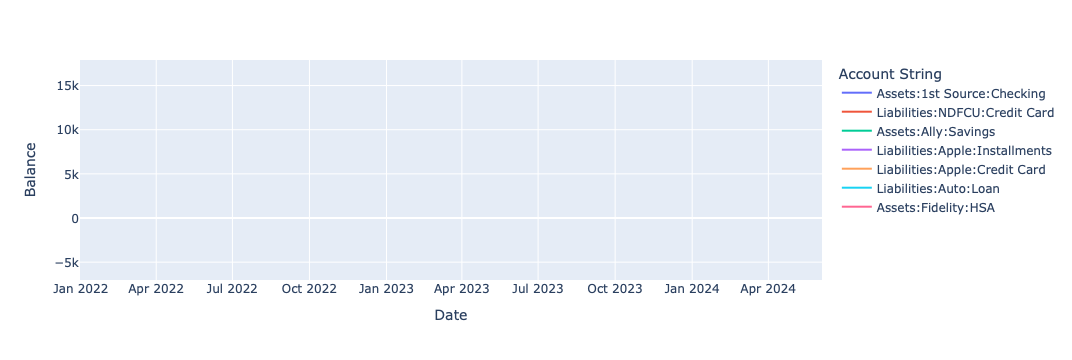

In [28]:
px.line(ledgers[ledgers["Type"].isin(["Assets", "Liabilities"])], x="Date", y="Balance", color="Account String")

In [29]:
budget = {}
for idx in pdextension:
    budget[idx] = monthly_mean["Expenses"]
budget = pd.DataFrame(budget)

In [30]:
btrans = pd.DataFrame(budget.T.stack(["Account", "Subaccount"])).rename(columns={0:"Amount"})
#help(btrans.index)
#btrans["Account String"] = [":".join(("Expenses", a, b)) for a, b in zip(btrans.index.get_level_values("Account"),
#                                                           btrans.index.get_level_values("Subaccount"))]
#btrans=btrans.droplevel("Account")
#btrans=btrans.droplevel("Subaccount")

#def stripcolon(s):
#    if s.endswith(":"):
#        return s[:-1]
#    else:
#        return s
#btrans["To"] = btrans["Account String"].apply(stripcolon)

/var/folders/42/qqsltqsj6fl30wl4xm41gs4m0000gn/T/ipykernel_7814/1351139105.py:1: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



In [31]:
endassets = br.loc["Assets"]["End Balance"]
endliabilities = br.loc["Liabilities"]["End Balance"]

In [32]:
start = pd.DataFrame(pd.concat([endassets, endliabilities])).rename(columns={"End Balance": "Balance"})

In [33]:
start["Description"] = "Ending Balance"

In [34]:
expsum = btrans.groupby(level=0).sum()
#expsum["Balance"] = expsum.cumsum()

In [35]:
expsum

Amount
2024-07  4405.019474
2024-08  4405.019474
2024-09  4405.019474
2024-10  4405.019474
2024-11  4405.019474
2024-12  4405.019474

In [36]:
budget

2024-07     2024-08     2024-09     2024-10  \
Account          Subaccount                                                     
Amazon                          35.627368   35.627368   35.627368   35.627368   
Auto             Fuel           49.575789   49.575789   49.575789   49.575789   
                 Gas             4.219474    4.219474    4.219474    4.219474   
                 Insurance      59.016316   59.016316   59.016316   59.016316   
                 Maintenance    24.786316   24.786316   24.786316   24.786316   
                 Registration   25.882632   25.882632   25.882632   25.882632   
                 Tolls           7.870526    7.870526    7.870526    7.870526   
Cash                            26.315789   26.315789   26.315789   26.315789   
Charity                          6.426316    6.426316    6.426316    6.426316   
Clothing                       113.066316  113.066316  113.066316  113.066316   
Electronics                    146.697895  146.697895  146.697895  146.697895   
Entertainment                  106.653684  106.653684  106.653684  106.653684   
                 Personal       15.607368   15.607368   15.607368   15.607368   
                 Reading         8.611053    8.611053    8.611053    8.611053   
                 Self           55.698421   55.698421   55.698421   55.698421   
Fitness          ID            201.315789  201.315789  201.315789  201.315789   
                 Recovery       14.473684   14.473684   14.473684   14.473684   
Gear                           154.711579  154.711579  154.711579  154.711579   
Gifts                           11.018421   11.018421   11.018421   11.018421   
Groceries                      630.402105  630.402105  630.402105  630.402105   
Home                            90.366316   90.366316   90.366316   90.366316   
                 Cleaning      241.421053  241.421053  241.421053  241.421053   
                 Furnishings   102.840000  102.840000  102.840000  102.840000   
                 Maintenance   161.052632  161.052632  161.052632  161.052632   
                 Mortgage      614.924211  614.924211  614.924211  614.924211   
                 Repair         10.392632   10.392632   10.392632   10.392632   
Home Furnishings                16.658421   16.658421   16.658421   16.658421   
Interest                        13.162632   13.162632   13.162632   13.162632   
Medical          Body           65.991579   65.991579   65.991579   65.991579   
                 Dentist         6.000000    6.000000    6.000000    6.000000   
                 Recovery        4.212105    4.212105    4.212105    4.212105   
                 Therapy       153.931579  153.931579  153.931579  153.931579   
Misc                            14.997895   14.997895   14.997895   14.997895   
Personal                        31.741579   31.741579   31.741579   31.741579   
Pet                            269.807895  269.807895  269.807895  269.807895   
                 Care           31.842105   31.842105   31.842105   31.842105   
Projects                        30.779474   30.779474   30.779474   30.779474   
Recovery                        13.470526   13.470526   13.470526   13.470526   
Reimbursable                   -35.226316  -35.226316  -35.226316  -35.226316   
Reimbursible                    31.467895   31.467895   31.467895   31.467895   
Restaurants                    174.842105  174.842105  174.842105  174.842105   
Services                         3.155263    3.155263    3.155263    3.155263   
Study                           25.822105   25.822105   25.822105   25.822105   
Subscriptions                  139.042632  139.042632  139.042632  139.042632   
Travel                         101.600526  101.600526  101.600526  101.600526   
Utilities                      392.745789  392.745789  392.745789  392.745789   

                                  2024-11     2024-12  
Account          Subaccount                            
Amazon                          3

In [37]:
dfs = {}
keep = ["Date", "Description", "Account String"]
accts = []
for typ in ["Assets", "Liabilities", "Transfer"]:
    accts.append(pd.unique(ledgers[ledgers["Type"] == typ]["Account String"]))
accts = np.concatenate(accts)

bals = []
grouped = ledgers.groupby("Account String")
for acct in accts:
    bals.append(grouped.get_group(acct)["Balance"].rename("Balance " + acct))

balance_table=pd.concat([ledgers[keep], pd.concat(bals, axis="columns")], join="inner", axis="columns").sort_values("Date").ffill().fillna(0)

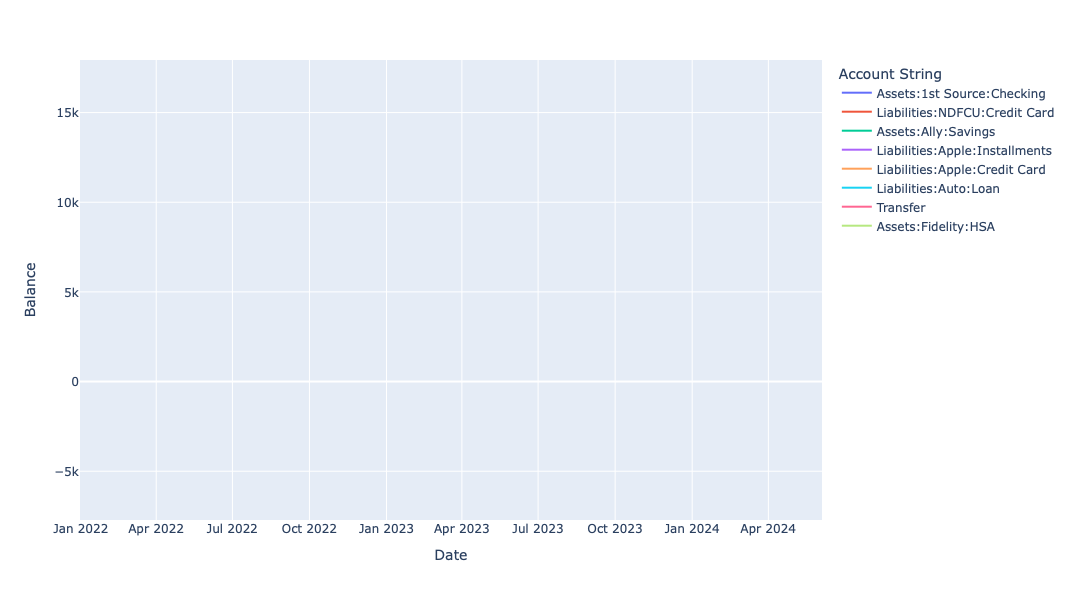

In [38]:
px.line(ledgers[ledgers["Type"].isin(["Assets", "Liabilities", "Transfer"])].set_index("Date"),
        y="Balance", color="Account String", height=600)

In [39]:
pd.set_option('display.max_rows', 100, 'display.max_columns', None)
#bank_tables["Liabilities:Apple:Installments
balance_table[balance_table["Balance Transfer"] == 0]

Date                                        Description  \
0    2021-12-31                                    Initial Balance   
1    2021-12-31  MARTIN S SUPERMARKE      . SOUTHBEND    . IN 0000   
2    2021-12-31  PHILLIPS 66 - 0082 FIR   . MISHAWAKA    . IN 0000   
4    2021-12-31                                    Initial Balance   
10   2021-12-31                                    Initial Balance   
...         ...                                                ...   
5138 2024-04-29                                   INTEREST PAYMENT   
5155 2024-04-30                    MONTHLY INSTALLMENTS (24 OF 24)   
5153 2024-04-30                    MONTHLY INSTALLMENTS (24 OF 24)   
5151 2024-04-30                     MONTHLY INSTALLMENTS (3 OF 12)   
5150 2024-04-30   REINVESTMENT FIDELITY GOVERNMENT CASH RESERVE...   

                      Account String  Balance Assets:1st Source:Checking  \
0         Assets:1st Source:Checking                             5067.54   
1      Liabilities:NDFCU:Credit Card                             5067.54   
2      Liabilities:NDFCU:Credit Card                             5067.54   
4                Assets:Ally:Savings                             5067.54   
10    Liabilities:Apple:Installments                             5067.54   
...                              ...                                 ...   
5138      Assets:1st Source:Checking                             1339.93   
5155   Liabilities:Apple:Credit Card                             1339.93   
5153  Liabilities:Apple:Installments                             1339.93   
5151  Liabilities:Apple:Installments                             1339.93   
5150             Assets:Fidelity:HSA                             1339.93   

      Balance Assets:Ally:Savings  Balance Assets:Fidelity:HSA  \
0                            0.00                         0.00   
1                            0.00                         0.00   
2                            0.00                         0.00   
4                         8028.68                         0.00   
10                        8028.68                         0.00   
...                           ...                          ...   
5138                     11604.81                      5333.05   
5155                     11604.81                      5333.05   
5153                     11604.81                      5333.05   
5151                     11604.81                      5333.05   
5150                     11604.81                      5354.79   

      Balance Liabilities:NDFCU:Credit Card  \
0                                      0.00   
1                                    -86.95   
2                                   -113.88   
4                                   -113.88   
10                                  -113.88   
...                                     ...   
5138                                1052.07   
5155                                1052.07   
5153                                1052.07   
5151                                1052.07   
5150                                1052.07   

      Balance Liabilities:Apple:Installments  \
0                                       0.00   
1                                       0.00   
2                                       0.00   
4                                       0.00   
10                                   -738.94   
...                                      ...   
5138                                -2150.97   
5155                                -2150.97   
5153                                -1836.99   
5151                                -1891.23   
5150                                -1891.23   

      Balance Liabilities:Apple:Credit Card  Balance Liabilities:Auto:Loan  \
0                                      0.00                   0.000000e+00   
1                                      0.00                   0.000000e+00   
2                                      0.00                   0.000000e+00   
4         

In [40]:
asgrouped = ledgers.groupby("Account String")["Incoming Amount"].sum()
asgrouped.name="Asset String"
tpgrouped = ledgers.groupby("Transaction Pair")["Incoming Amount"].sum()
tpgrouped.name="Transaction Pair"

In [41]:
pd.options.display.float_format = '{:,.2f}'.format


check = pd.concat([asgrouped,-1 *  tpgrouped], axis="columns")#.rename(columns={"Incoming Amount"Asset String", 1:"Transaction Pair"})

In [43]:
check[check["Asset String"] != check["Transaction Pair"]].assign(Diff=check["Asset String"] - check["Transaction Pair"])

Asset String  Transaction Pair  Diff
Assets:1st Source:Checking         6,675.63          6,675.63 -0.00
Liabilities:Apple:Credit Card     -1,572.51         -1,572.51 -0.00
Liabilities:NDFCU:Credit Card      1,052.07          1,052.07  0.00

In [44]:
final_balance = ledgers.groupby(ACCT_NAMES)["Incoming Amount"].sum()

In [53]:
pd.Period(trans["Date"].max() - trans["Date"].min())

ValueError: Value must be Period, string, integer, or datetime

In [52]:
trans.groupby(["From", "To"]).sum("Amount") / (trans["Date"].max() - trans["Date"].min())

UFuncTypeError: ufunc 'divide' cannot use operands with types dtype('float64') and dtype('<m8[ns]')

In [ ]:
df = monthly_mean["Income"]

fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    valuesuffix = "TWh",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  data['data'][0]['node']['label'],
      color =  data['data'][0]['node']['color']
    ),
    # Add links
    link = dict(
      source =  data['data'][0]['link']['source'],
      target =  data['data'][0]['link']['target'],
      value =  data['data'][0]['link']['value'],
      label =  data['data'][0]['link']['label'],
      color =  data['data'][0]['link']['color']
))])

fig.update_layout(title_text="Energy forecast for 2050<br>Source: Department of Energy & Climate Change, Tom Counsell via <a href='https://bost.ocks.org/mike/sankey/'>Mike Bostock</a>",
                  font_size=10)
fig.show()